In [1]:
%pylab inline
from matustools.matustats import lognorm
from matustools.matusplotlib import *

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib-1.5.0-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import os, pystan
from scipy import stats
#from matustools.matustats import lognorm
#from matustools.matusplotlib import *
np.random.seed(4)

ipath= os.getcwd().rstrip('code')+'behavioralOutput'+os.path.sep
opath= os.path.sep.join([os.getcwd().rstrip('code')+'evaluation','behData',''])

def loadData(vpn, verbose=False):
    D=[]
    for vp in vpn:
        dat=np.loadtxt(ipath+'vp%03d.res'%vp)
        if verbose: print vp, dat.shape
        D.append(dat[dat[:,1]>0,:])
    D=np.concatenate(D,0)
    return D

BLMAX=4 # maximum number of block per subject
T=40 # number of trials
vpn=range(20,70) # subject ids
D=loadData(vpn)

acc=-2*np.ones((len(vpn),BLMAX*T),dtype=int) # detection accuracy
rts=-2*np.ones((len(vpn),BLMAX*T)) # detection speed
rejs=-np.ones((len(vpn),BLMAX*T),dtype=int) # 1 - trial with min dist 3 deg
for i in range(len(vpn)):
    sel= D[:,0]==vpn[i]
    acc[i,:sel.sum()]= D[sel,-1]
    rts[i,:sel.sum()]= D[sel,6]
    rejs[i,:sel.sum()]=np.int32(D[sel,3]<35)

# code ommisions with -1    
acc[rts==30]=-1
rts[rts==30]=-1

# data format for stan
D={'N':rts.shape[0],'T':rts.shape[1],'rts': rts,'acc':acc,'rejs':rejs}

In [50]:
#metadata
md=np.loadtxt(ipath+'vpinfo.res',delimiter=',')
md=np.int32(md)
N=md.shape[0]
print 'mean age={:.2f}, range ({},{})'.format(md[:,1].mean(),np.min(md[:,1]),np.max(md[:,1]) )
print 'female={}, male={}'.format(N-md[:,2].sum(),md[:,2].sum())
print 'nr of subjects with 4 blocks {}'.format(((rts==-2).sum(1)==0).sum())
epath= os.getcwd().rstrip('code')+'eyelinkOutput'+os.path.sep
etexists=np.zeros((N,4),dtype=np.int32)
for vpi in range(len(vpn)):
    for b in range(4):
        etexists[vpi,b]=int(os.path.isfile(epath+'VP{:03d}B{}.ASC'.format(vpn[vpi],b+1)))
print '\n missing ET data'
print np.array([range(5), np.histogram(etexists.sum(1),range(6))[0]])

mean age=22.54, range (18,48)
female=43, male=7
nr of subjects with 4 blocks 32

 missing ET data
[[ 0  1  2  3  4]
 [14  1  0 14 21]]


[14  1  0 14 21]


In [3]:
# stan model

m1="""
data {
    int<lower=0> N; // number of subjects
    int<lower=0> T; // number of trials
    int rejs[N,T]; // trial type; 1 - minimun dist constraint, 0 - no constraint
    int acc[N,T]; // accuracy; 1 - correct, 0 - incorrect
    real rts[N,T]; // reaction time in seconds
}
parameters {
    vector<lower=0,upper=10>[4] rtac[N]; // mean rt for constraint trials
    real<lower=0,upper=10> rtsd[N,2];
    vector<lower=0,upper=10>[4] hm;
    vector<lower=0,upper=10>[4] hsd;
    corr_matrix[4] r;
}
model {
    matrix[4,4] tempSigma;
    r~lkj_corr(1);
    tempSigma<-quad_form_diag(r,hsd);
    for (n in 1:N){
        rtac[n]~multi_normal(hm,tempSigma);
    for (t in 1:T){
    if(rts[n,t]>-1){
        rts[n,t]~lognormal(rtac[n][1+rejs[n,t]*2],rtsd[n,rejs[n,t]+1]);
        acc[n,t]~bernoulli_logit(rtac[n][2+rejs[n,t]*2]);
    } else if (rts[n,t]==-1){
        increment_log_prob(log1m(lognormal_cdf(30.0,
            rtac[n][1+rejs[n,t]*2],rtsd[n,rejs[n,t]+1])));
    }}}
}"""
m2=m1.replace('rtsd[n,','rtsd[');m2=m2.replace('rtsd[N,','rtsd[')
m3=m1.replace('r~lkj_corr(1);','r~lkj_corr(1);\nr[1,3]<-0;r[1,4]<-0;r[2,3]<-0;r[2,4]<-0;')
m4=m2.replace('r~lkj_corr(1);','r~lkj_corr(1);\nr[1,3]<-0;r[1,4]<-0;r[2,3]<-0;r[2,4]<-0;')
models=[[m1,'RtsdAllFullS'],
        [m2,'RtsdFullS']]
        #[m3,'RtsdAllSparseS'],
        #[m4,'RtsdSparseS']]#,[m2,'RTCnopool']]

In [6]:
for m in models:
    sm=pystan.StanModel(model_code=m[0],model_name=m[1])
    m.append(sm)
#m3=m1.replace('rtsd[n])))','rtsd[n]+ncsd*rejs[n,t])))')
#smC=pystan.StanModel(model_code=m3,model_name='HierarchicalRTchoiceRtsdXcond')

In [5]:
fits=[]
for model in models:
    fit=model[2].sampling(data=D,iter=1000,chains=8,seed=np.random.randint(2**16),
                          warmup=500,thin=1,n_jobs=8)
    fits.append(fit)
    saveStanFit(fit,opath+model[1])

In [4]:
for m in models:
    m.append(loadStanFit(opath+m[1]))

In [116]:
def diagnostics(w,nrchains,decim=2,short=False):
    def computeDiag(d,prefix):
        if d.ndim==1:
            crit=False
            vals=[np.median(d)]
            d=np.array(d,ndmin=2)
            for lag in [1,2,5,10,20]:
                vals.append(np.abs(np.corrcoef(d,np.roll(d,lag))[0,1]))
                if vals[-1]>=0.1: crit=True
            d=d.reshape([nrchains,d.size/nrchains])
            W=np.var(d,axis=1).mean()
            B=d.mean(1).var()
            V=W*(1-nrchains/float(d.size))+B
            R=np.sqrt(V/W)
            vals.append(np.round(R,decim))
            if vals[-1]>=1.05: crit=True
            s= prefix+']'
            if len(s)<8: s+='\t'
            for v in vals:
                s+='\t'+str(np.round(v,decim))
            s+=['\t\t','\t*\t'][crit]+'\n'
            if short and not crit: s=''
            return s
        elif d.ndim>1:
            s='';k=0
            for dd in d:
                s+=computeDiag(dd,prefix+str(k)+['',','][dd.ndim>1])
                k+=1
            return s    
        else: 
            raise ValueError
    s='varname\t\tvarval\trlag1\trlag2\trlag5\trlag10\trlag20\tR\tCRIT\n'
    if short: s+='LISTING ONLY CRITICAL VARIABLES\n'
    for k in w.keys():
        d=w[k]    
        d=rollaxis(d,0,d.ndim)        
        s+=computeDiag(d,k+'[')
    return s
#print diagnostics(models[1][-1],8)

/home/drsimkovic/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:293: RuntimeWarning: invalid value encountered in true_divide
  return n/(n*db).sum(), bins


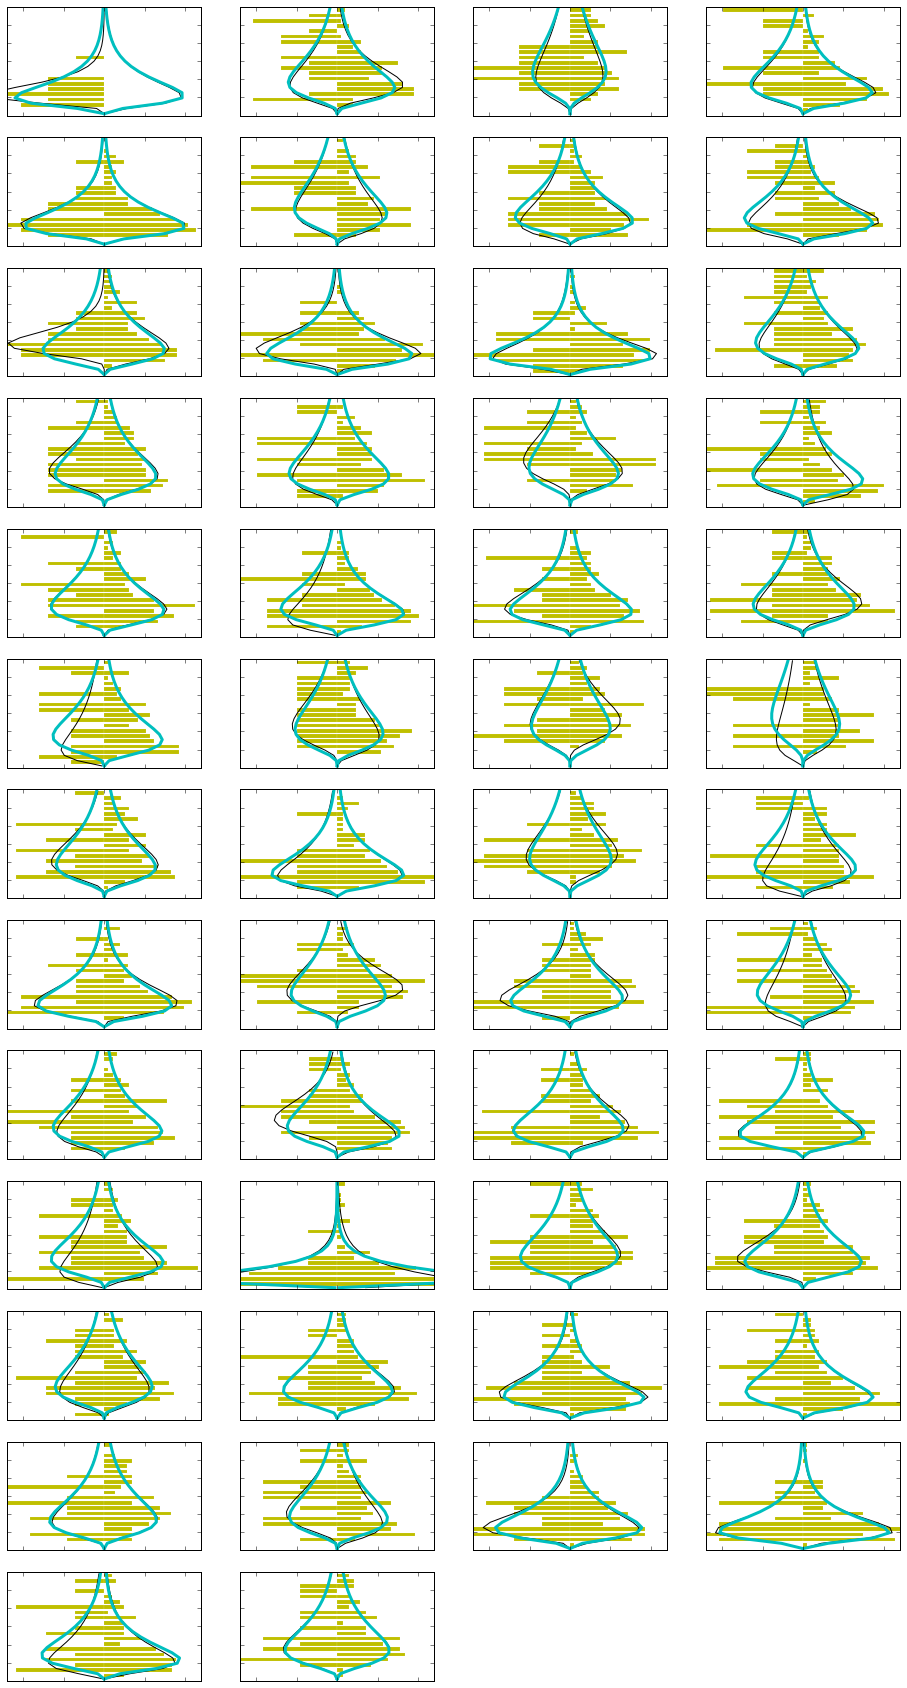

In [112]:
plt.figure(figsize=(16,30))
for vp in range(rts.shape[0]):
    plt.subplot(13,4,vp+1)
    x=np.linspace(1,30,21)
    d=rts[vp,rejs[vp,:]==0]
    d=d[d>0]
    a=np.histogram(d,bins=x,normed=True)
    plt.barh(x[:-1],-a[0],ec='w',fc='y',height=1,lw=0.1)
    d=rts[vp,rejs[vp,:]==cond]
    d=d[d>0]
    a=np.histogram(d,bins=x,normed=1)
    plt.barh(x[:-1],a[0],ec='w',fc='y',height=1,lw=0.1)
    plt.xlim([-0.12,0.12])
    plt.ylim([0,30])
    ax=plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #varc=np.square(w['rtac'])[:,vp,0]
    #vard=np.square(w['rtsd'])[:,vp]
    #rtmc.append([np.exp(w['rtmc']+varc/2.),
    #             np.exp(w['rtmd']+vard/2.),
    #             #np.sqrt((np.exp(varc)-1)*np.exp(2*w['rtmc']+varc)),
    #             #np.sqrt((np.exp(vard)-1)*np.exp(2*w['rtmd']+vard)),
    #             w['csrate'],w['dsrate'],
    #             w['rtmc'],w['rtsc']])
    for cond in range(2):
        w=models[0][-1]
        plt.plot((-1)**(1-cond)*lognorm(mu=np.median(w['rtac'][:,vp,2*cond]),
            sigma=np.median(w['rtsd'][:,vp,cond])).pdf(x-0.5),x-0.5,color='k',lw=1)
        w=models[1][-1]
        plt.plot((-1)**(1-cond)*lognorm(mu=np.median(w['rtac'][:,vp,2*cond]),
            sigma=np.median(w['rtsd'][:,cond])).pdf(x-0.5),x-0.5,color='c',lw=3)

Two questions are investigate:

* Is there a speed-accuracy trade-off?
* How do the two conditions differ?

To investigate these research questions we fit the following model. 

* Lognormal model is used for response times. $\log(\mathrm{RT}_{n,i}) \sim \mathcal{N}(\mu_n,\sigma_n)$ where $\mathrm{RT}_{n,i}$ is the response time of subject $n$ on trial $t$ and $\mu_n$ is the mean parameter and $\sigma_n$ is the scale parameter of the lognormal distribution for subject $n$.

* For each omission (i.e. trial on which the chase was not detected) the model likelihood was multiplied  by $1-\mathrm{cdf}(30;\mu_n,\sigma_n)$ where $\mathrm{cdf}$ is the cummulative density function of a lognormal distribution.

* Logit model was used to fit the hits and misses: $\mathrm{AC}_{n,i} \sim \mathrm{Bernoulli}(\mathrm{logit}(\theta_n))$ where $\mathrm{AC}_{n,i}$ is hit (1) or miss (0) of subject $n$ on trial $i$, $\mathrm{Bernoulli}$ is the Bernoulli distribution, $\mathrm{logit}(x)=\log(x/(1-x))$ and  $\theta_n$ is a summary accuracy parameter of subject $n$ on a continuous scale. 

* We fitted a separate set of $\mu_n$ and $\theta_n$ for each of the two conditions (DC, NC). 

* The lognormal and logit model match well the distribution of the data and as a consequence the distribution $\mu_n$ and $\theta_n$ approximately matches the multivariate normal distribution. To estimate the corresponding population values a hierarchical prior is used to model $\mu_n$ and $\theta_n$ $$\pmatrix{\mu_n^{\mathrm{DC}} \\ \theta_n^{\mathrm{DC}} \\ \mu_n^{\mathrm{NC}} \\ \theta_n^{\mathrm{NC}}} \sim \mathcal{N}(\nu,\Sigma) $$ where $\nu$ is the mean and $\Sigma$ is the covariance matrix.

* $\Sigma$ is decomposed as $\Sigma=HRH^T$ where $R$ is the corresponding correlation matrix and $H$ is a diagonal matrix with standard deviations on the diagonal. 

* We applied eigenvalue decomposition to the correlation matrix $R=U\Lambda U^T$, where $\Lambda$ contains eigenvalues on the diagonal and the columns of $U$ contain eigenvectors. 

In [119]:
from matustools.matusplotlib import *
lbls=['\mu_n^\mathrm{DC}','\theta_n^\mathrm{DC}','\mu_n^\mathrm{DC}','\theta_n^\mathrm{NC}']
for i in range(4):
    for j in range(i+1,4):
        print '$r('+lbls[i]+','+lbls[j] +')$',
        printCI(models[0][-1]['r'][:,i,j])

$r(\mu_n^\mathrm{DC},	heta_n^\mathrm{DC})$  0.331 [-0.029,0.591]
 0.302 [-0.036,0.597]
$r(\mu_n^\mathrm{DC},\mu_n^\mathrm{DC})$  0.852 [0.677,0.938]
 0.858 [0.690,0.948]
$r(\mu_n^\mathrm{DC},	heta_n^\mathrm{NC})$  0.433 [0.118,0.651]
 0.397 [0.093,0.649]
$r(	heta_n^\mathrm{DC},\mu_n^\mathrm{DC})$  0.506 [0.240,0.712]
 0.512 [0.235,0.724]
$r(	heta_n^\mathrm{DC},	heta_n^\mathrm{NC})$  0.906 [0.730,0.987]
 0.898 [0.726,0.976]
$r(\mu_n^\mathrm{DC},	heta_n^\mathrm{NC})$  0.442 [0.172,0.642]
 0.433 [0.192,0.650]


 0.683 [0.553,0.784]
 0.255 [0.167,0.381]


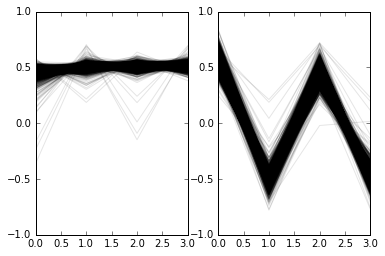

In [114]:
r=models[0][-1]['r']
varexp=[]
for k in range(r.shape[0]):
    lam,sc=np.linalg.eigh(r[k,:,:])
    sgn=np.sign(sc[:,-1].mean())
    plt.subplot(1,2,1)
    plt.plot(sgn*sc[:,-1],'k',alpha=0.1)
    plt.subplot(1,2,2)
    sgn=np.sign(sc[0,-2])
    plt.plot(sgn*sc[:,-2],'k',alpha=0.1)
    varexp.append(lam/lam.sum())
plt.ylim([-1,1]);
plt.subplot(1,2,1)
plt.ylim([-1,1]);
varexp=np.array(varexp)
printCI(varexp[:,-1])
printCI(varexp[:,-2])

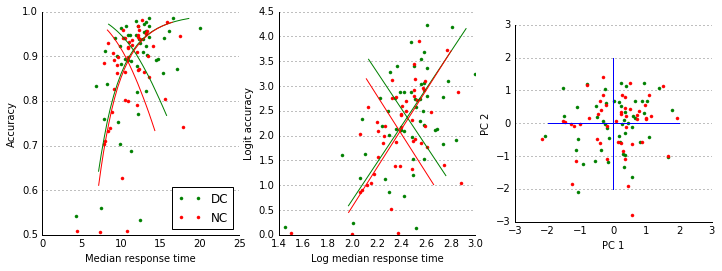

In [79]:
figure(figsize=(12,4))
# subject means on the latent scale
rtac=np.copy(models[0][-1]['rtac'])
# population params
hsd=models[0][-1]['hsd']
hm=models[0][-1]['hm']
###########################
# subject scores
###########################
#compute subject scores on the data scale
rtacD=np.array([np.exp(rtac[:,:,0]),1/(1+np.exp(-rtac[:,:,1])),
               np.exp(rtac[:,:,2]), 1/(1+np.exp(-rtac[:,:,3]))])
rtacD=np.median(rtacD,1).T
rtacL=np.median(rtac,0) # latent scale
# orthonormal scale
lam=[1.4,0.6];lamSq=np.diag(np.sqrt(lam));lamSqI=np.diag(np.power(lam,-0.5))
phi=np.pi/4
U=np.matrix([[np.cos(phi),-np.sin(phi)],[np.sin(phi),np.cos(phi)]]);UI=U.T
H=hsd;HI=1/H
mu=hm
rtacP=np.copy(rtac)
for n in range(rtacP.shape[1]): rtacP[:,n,:]-=hm
for k in range(rtacP.shape[0]):rtacP[k,:,:2]=(lamSqI*UI*np.diag(HI[k,:2])*rtacP[k,:,:2].T).T
for k in range(rtacP.shape[0]):rtacP[k,:,2:]=(lamSqI*UI*np.diag(HI[k,2:])*rtacP[k,:,2:].T).T
rtacP=np.median(rtacP,0)
# plot subject scores
subplot(1,3,1)# data scale
plt.plot(rtacD[:,0],rtacD[:,1],'g.')
plt.plot(rtacD[:,2],rtacD[:,3],'r.')
plt.xlim([0,25])
plt.xlabel('Median response time')
plt.ylabel('Accuracy')
plt.legend(['DC','NC'],loc=4)
subplot(1,3,2) # latent scale
plt.plot(rtacL[:,0],rtacL[:,1],'g.')
plt.plot(rtacL[:,2],rtacL[:,3],'r.')
plt.xlabel('Log median response time')
plt.ylabel('Logit accuracy')
subplot(1,3,3) # orthonormal scale
plt.plot(rtacP[:,0],rtacP[:,1],'g.')
plt.plot(rtacP[:,2],rtacP[:,3],'r.')
plt.xlim([-3,3]);plt.ylim([-3,3]);
plt.xlabel('PC 1');plt.ylabel('PC 2')
plt.gca().set_aspect(1)
###########################
# pc axes
###########################
# orthonormal scale
pcP=[[-2,0],[2,0],[0,-2],[0,2]]
pcP=np.array(pcP)
plt.plot(*pcP[:2,:].T.tolist(),color='b')
plt.plot(*pcP[2:,:].T.tolist(),color='b')
subplot(1,3,2)# latent scale
pcL=np.zeros((hm.shape[0],pcP.shape[0],pcP.shape[1],2))
for k in range(pcL.shape[0]):
    pcL[k,:,:,0]=(np.diag(H[k,:2])*U*lamSq*pcP.T).T+hm[k,:2]
    pcL[k,:,:,1]=(np.diag(H[k,2:])*U*lamSq*pcP.T).T+hm[k,2:]
plt.plot(*np.median(pcL,0)[:2,:,0].T.tolist(),color='g')
plt.plot(*np.median(pcL,0)[2:,:,0].T.tolist(),color='g')
plt.plot(*np.median(pcL,0)[:2,:,1].T.tolist(),color='r')
plt.plot(*np.median(pcL,0)[2:,:,1].T.tolist(),color='r')
subplot(1,3,1)# data scale
N=21;shp=list(pcL.shape);shp[1]=N*2
pcD=np.zeros(shp)
for a in range(shp[0]):
    for b in range(shp[-1]):
        pcD[a,:N,0,b]=np.exp(np.linspace(pcL[a,0,0,b],pcL[a,1,0,b],N))
        pcD[a,N:,0,b]=np.exp(np.linspace(pcL[a,2,0,b],pcL[a,3,0,b],N))
        pcD[a,:N,1,b]=1/(1+np.exp(-np.linspace(pcL[a,0,1,b],pcL[a,1,1,b],N)))
        pcD[a,N:,1,b]=1/(1+np.exp(-np.linspace(pcL[a,2,1,b],pcL[a,3,1,b],N)))
        #pcD[:,:,1,:]=1/(1+np.exp(-pcL[:,:,1,:]))
plt.plot(*np.median(pcD,0)[:N,:,0].T.tolist(),color='g')
plt.plot(*np.median(pcD,0)[N:,:,0].T.tolist(),color='g')
plt.plot(*np.median(pcD,0)[:N,:,1].T.tolist(),color='r')
plt.plot(*np.median(pcD,0)[N:,:,1].T.tolist(),color='r')

In [8]:
w=models[0][-1]
res=[]
for k in range(w['r'].shape[0]):
    r=w['r'][k,:2,:2]
    lam,eigv=np.linalg.eigh(r)
    if eigv[0,0]!=eigv[1,0]: lam=np.roll(lam,1);eigv=np.roll(eigv,1);
    if eigv[0,0]<0: eigv*=-1
    res1=np.diag(1/np.sqrt(lam))*np.matrix(eigv).T*np.array((hm[k,:2]-hm[k,2:])/hsd[k,2:],ndmin=2).T
    r=w['r'][k,2:,2:]
    lam,eigv=np.linalg.eigh(r)
    if eigv[0,0]!=eigv[1,0]: lam=np.roll(lam,1);eigv=np.roll(eigv,1);
    if eigv[0,0]<0: eigv*=-1
    res2=np.diag(1/np.sqrt(lam))*np.matrix(eigv).T*np.array((hm[k,2:]-hm[k,:2])/hsd[k,:2],ndmin=2).T
    res.append([res1,res2])
res=np.array(res)
printCI(res[:,0,0,0])
printCI(res[:,0,1,0])
printCI(-res[:,1,0,0])
printCI(-res[:,1,1,0])

 0.333 [0.084,0.624]
 0.046 [-0.386,0.488]
 0.285 [0.096,0.478]
 0.055 [-0.326,0.432]


In [9]:
w=models[0][-1]
res=[]
for k in range(w['r'].shape[0]):
    r=np.diag(hsd[k,:2]).dot(w['r'][k,:2,:2]).dot(np.diag(hsd[k,:2]))
    lam,eigv=np.linalg.eigh(r)
    if eigv[0,0]!=eigv[1,0]: lam=np.roll(lam,1);eigv=np.roll(eigv,1);
    if eigv[0,0]<0: eigv*=-1
    res1=np.diag(1/np.sqrt(lam))*np.matrix(eigv).T*np.array((hm[k,:2]-hm[k,2:]),ndmin=2).T
    r=np.diag(hsd[k,2:]).dot(w['r'][k,2:,2:]).dot(np.diag(hsd[k,2:]))
    lam,eigv=np.linalg.eigh(r)
    if eigv[0,0]!=eigv[1,0]: lam=np.roll(lam,1);eigv=np.roll(eigv,1);
    if eigv[0,0]<0: eigv*=-1
    res2=np.diag(1/np.sqrt(lam))*np.matrix(eigv).T*np.array((hm[k,2:]-hm[k,:2]),ndmin=2).T
    res.append([res1,res2])
res=np.array(res)
printCI(res[:,0,0,0])
printCI(res[:,0,1,0])
printCI(-res[:,1,0,0])
printCI(-res[:,1,1,0])

 0.081 [0.016,0.150]
 -0.132 [-0.428,0.186]
 0.096 [0.023,0.181]
 -0.123 [-0.497,0.288]


Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 50
         Function evaluations: 96
[ 0.87059779  0.28260394]


(-0.03, 0.03)

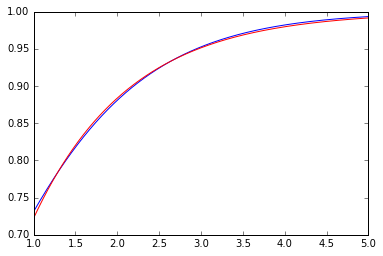

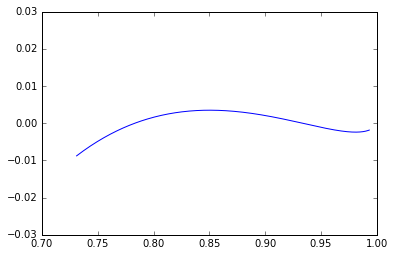

In [104]:
x=np.linspace(1,5,501)
y1=1/(1+np.exp(-x))
plt.plot(x,y1)
n=10
#y2=1/(1+np.power(1-x/n,n))
#plt.plot(x,y2)


def errfun(th):
    return np.square(1-np.exp(-x*th[0]+th[1])/2-y1).mean()
from scipy.optimize import fmin
th=fmin(errfun,[0.7,0])
y3=1-np.exp(-x*th[0]+th[1])/2
plt.plot(x,y3,'r')
print th
plt.figure()
plt.plot(y1,y3-y1);plt.ylim([-0.03,0.03])

In [109]:
d=(pcL[:,1,:,0]-hm[:,:2])/2
printCI(np.exp(d[:,0]))
printCI(np.exp(-d[:,1]*th[0]+th[1]))
d=(pcL[:,3,:,0]-hm[:,:2])/2
printCI(np.exp(d[:,0]))
printCI(np.exp(-d[:,1]*th[0]+th[1]))

 1.271 [1.203,1.361]
 0.610 [0.458,0.742]
 0.855 [0.817,0.886]
 0.798 [0.661,0.907]


In [108]:
pcL.shape

(4000, 4, 2, 2)